# Tuning Script

In [7]:
# Parameters subject to change in every script - involved in naming

MODEL = 'lgbc'
FEATURE_IMPORTANCE_ORDERING = 'xgb'
PREPROCESSING = 'Baseline'
TUNER = 'jiaochengb-balaccu'
FEATURE_ENGINEERING = 'tfidf'
EXPERIMENT = 'burstiness'

---

In [8]:
# detect whether this is a google environment

COLAB_ENVIRONMENT = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    COLAB_ENVIRONMENT = True
except:
    pass

In [9]:
import sys
import os
import pickle
from scipy.sparse import load_npz

if COLAB_ENVIRONMENT:
    py_file_location = "./drive/MyDrive/LAB/COMP90051-A1__Groupwork__Py/PrivatePackages" # my private packages are stored here
    home_directory = './drive/MyDrive/LAB/COMP90051-A1__Groupwork__Py/' # my home directory is stored in ./LAB of google drive
    if MODEL == 'ebc':
        !pip install interpret==0.5.0
    elif MODEL == 'cbc':
        !pip install catboost
else:
    py_file_location = '../../PrivatePackages'
    home_directory = '../../'

sys.path.append(os.path.abspath(py_file_location))

from Tuners import JiaoChengB_BalAccu

import pandas as pd

In [10]:
## Parameters that are same for every script

SEED = 2608

TASK_TYPE = 'Classification' # this task is a classification task

TUNE_FEATURES_AS_HYPERPARAMETERS = False # we have decided to tune features as hp

---

In [11]:
# model to use to tune
from lightgbm import LGBMClassifier as clf

# what values to try for each hyperparameter
parameter_choices = {
    'n_estimators': (25, 50, 100, 200, 400, 800),
    'max_depth': (3, 6, 12, 24, 48, 96, 192),
    'subsample': (0.4, 0.55, 0.7, 0.85, 1),
    'colsample_bytree': (0.4, 0.55, 0.7, 0.85, 1),
    'learning_rate': (0.00000001, 0.000001, 0.0001, 0.01, 0.1),
    'reg_alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10)
}

# what values to set non-tuneable parameters/hyperparameters
non_tunable_hyperparameters_dict = {
                                    'random_state': 19260817,
                                    'n_jobs': -1,
                                    'warnings': 'none'
                                    }

tuning_order = [
    # 'features',
    'max_depth',
    'subsample',
    'colsample_bytree',
    'n_estimators',
    'reg_alpha',
    'learning_rate',
]

default_hyperparameter_values = {'n_estimators': 100, 'max_depth': 12, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.01, 'learning_rate': 0.01, 'features': 0}
default_hyperparameter_values = {'n_estimators': 100, 'max_depth': 12, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.01, 'learning_rate': 0.01}

---

Read in and Prepare Data

In [12]:
train_x = load_npz(home_directory + f'data/curated/baseline/train_{FEATURE_ENGINEERING}_{EXPERIMENT}_x.npz')
val_x = load_npz(home_directory + f'data/curated/baseline/val_{FEATURE_ENGINEERING}_{EXPERIMENT}_x.npz')
test_x = load_npz(home_directory + f'data/curated/baseline/test_{FEATURE_ENGINEERING}_{EXPERIMENT}_x.npz')

with open(home_directory + f'data/curated/baseline/train_{EXPERIMENT}_y.pkl', 'rb') as f:
    train_y = pickle.load(f)
with open(home_directory + f'data/curated/baseline/val_{EXPERIMENT}_y.pkl', 'rb') as f:
    val_y = pickle.load(f)
with open(home_directory + f'data/curated/baseline/test_{EXPERIMENT}_y.pkl', 'rb') as f:
    test_y = pickle.load(f)

In [13]:
# Import feature importance ordering

with open(f'{home_directory}models/{FEATURE_IMPORTANCE_ORDERING}_{FEATURE_ENGINEERING}_feature_importance_ordering_{EXPERIMENT}.pickle', 'rb') as f:
    feature_importance_ordering = pickle.load(f)

[LightGBM] [Info] Number of positive: 2799, number of negative: 9801


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349398
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 6926
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222143 -> initscore=-1.253222
[LightGBM] [Info] Start training from score -1.253222


<Figure size 5000x1000 with 0 Axes>

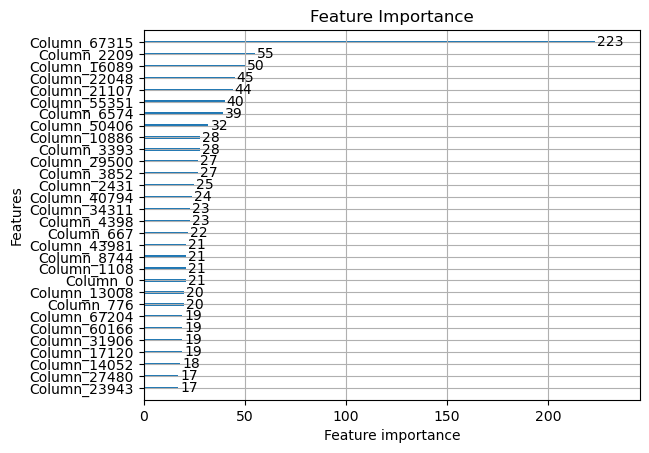

In [14]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Train your LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Assuming you have your training data in X_train and labels in y_train
train_data = lgb.Dataset(train_x, label=train_y)

# Train the model
model = lgb.train(params, train_data, num_boost_round=100)

# Get feature importance
feature_importance = model.feature_importance()

# Get feature names
feature_names = model.feature_name()

# Plot feature importance
plt.figure(figsize=(50, 10))
lgb.plot_importance(model, max_num_features=30) # Change max_num_features as needed
plt.title("Feature Importance")
plt.show()

Set parameters

In [15]:
# initialisation
tuner = JiaoChengB_BalAccu.JiaoChengB()

print('---')

# define what model we are tuning
tuner.read_in_model(clf, TASK_TYPE)

print('---')

# read in the data for training and validation
tuner.read_in_data(train_x, train_y, val_x, val_y, test_x, test_y)

print('---')

# set what hp values to tune
tuner.set_hyperparameters(parameter_choices)
# WARNING: this may take a while if no. tuneable hyperparameters are large

print('---')

# set up hp values that need to be changed from default but NOT to be tuned
tuner.set_non_tuneable_hyperparameters(non_tunable_hyperparameters_dict)

print('---')

# set up feature importance ordering

if TUNE_FEATURES_AS_HYPERPARAMETERS:
  tuner.set_features(feature_importance_ordering)
  # WARNING: this may take a while if no. tuneable hyperparameters are large

print('---')

# set up the order of hyperparameters when iteratively tuning using JiaoCheng
tuner.set_tuning_order(tuning_order)

print('---')

# set up the default hp values for first iteration of tuning JiaoCheng
tuner.set_hyperparameter_default_values(default_hyperparameter_values)

print('---')

# try: # try to read in previous results to continue tuning ...
#   tuner.read_in_tuning_result_df(f'{home_directory}models/tuning/{TUNER}_{MODEL}_{FEATURE_IMPORTANCE_ORDERING}_{FEATURE_ENGINEERING}_{PREPROCESSING}.csv')
# except:
#   print('No previous tuning data read in')

print('---')

# set up where to save the tuning result csv
tuner.set_tuning_result_saving_address(f'{home_directory}models/tuning_results/{TUNER}_{MODEL}_{FEATURE_IMPORTANCE_ORDERING}_{FEATURE_ENGINEERING}_{EXPERIMENT}_{PREPROCESSING}.csv')

print('---')

# set up where to save the current best model
tuner.set_best_model_saving_address(f'{home_directory}models/tmp_models/{TUNER}_{MODEL}_{FEATURE_IMPORTANCE_ORDERING}_{FEATURE_ENGINEERING}_{EXPERIMENT}_{PREPROCESSING}')

JiaoCheng Initialised
---
Successfully read in model <class 'lightgbm.sklearn.LGBMClassifier'>, which is a Classification model
---
Read in Train X data
Read in Train y data
Read in Val X data
Read in Val y data
Read in Test X data
Read in Test y data
---
Successfully recorded hyperparameter choices
---
Successfully recorded non_tuneable_hyperparameter choices
---
---
---
---
---
Successfully set tuning output address
---
Successfully set best model output address


In [16]:
# ignore warnings

import warnings
warnings.filterwarnings("ignore")

In [17]:
# begin tuning ... (or continue training)

tuner.tune()


Default combo: [2, 2, 2, 2, 3, 2] 


FEATURE_INDEX: 0 (max_depth) ROUND 1

Round 1 
Hyperparameter: max_depth (index: 1) 

[LightGBM] [Warning] Unknown parameter: warnings


[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Info] Number of positive: 2799, number of negative: 9801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.322793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349398
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 6926
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222143 -> initscore=-1.253222
[LightGBM] [Info] Start training from score -1.253222
[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warning] Unknown parameter: warnings
Trained and Tested combination 1 of 31500: (2, 0, 2, 2, 3, 2), taking 2.0 seconds to get val score of 0.5
        Current best combo: (2, 0, 2, 2, 3, 2) with val score 0.5
[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 

In [18]:
max_index = tuner.tuning_result['Test balanced_accu'].idxmax()
tuner.tuning_result.loc[max_index]

n_estimators                800.0
max_depth                    24.0
subsample                     0.7
colsample_bytree             0.55
learning_rate                 0.1
reg_alpha                     0.1
Train accu                    1.0
Val accu                 0.877407
Test accu                0.882222
Train balanced_accu           1.0
Val balanced_accu        0.785246
Test balanced_accu       0.788526
Train f1                      1.0
Val f1                   0.871753
Test f1                  0.876651
Train precision               1.0
Val precision            0.872253
Test precision           0.877296
Train recall                  1.0
Val recall               0.877407
Test recall              0.882222
Time                        22.23
random_state           19260817.0
n_jobs                       -1.0
warnings                     none
Train AP                      1.0
Val AP                   0.574686
Test AP                  0.579496
Train AUC                     1.0
Val AUC       

In [41]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import json

with open('../../models/tmp_models/jiaochengb-balaccu_lgbc_xgb_tfidf_burstiness_Baseline.pickle', 'rb') as f:
    clf = pickle.load(f)
# with open('../models/xgb_tfidf_feature_importance_ordering_Baseline.pickle', 'rb') as f:
#     feature_importance_ordering = pickle.load(f)


# data_test = []
# with open('../../data/raw/test_data.json', 'r') as f:
#     for line in f:
#         data_test.append(json.loads(line))

# future_tfidf = load_npz(f'../../data/curated/baseline/future_tfidf_{EXPERIMENT}_x.npz')

# create domain labels for data
val_pred = clf.predict(val_x)
test_pred = clf.predict(test_x)

print(balanced_accuracy_score(val_y, val_pred), balanced_accuracy_score(test_y, test_pred))

print()
print(val_x.shape[1])

val_domain = val_x[:, -1].transpose().toarray()
test_domain = test_x[:, -1].transpose().toarray()

val_dom1_pred = [val_pred[i] for i in range(len(val_pred)) if val_domain[0][i] == 1]
val_dom2_pred = [val_pred[i] for i in range(len(val_pred)) if val_domain[0][i] == 2]
val_dom1_true = [val_y.values[i] for i in range(len(val_y.values)) if val_domain[0][i] == 1]
val_dom2_true = [val_y.values[i] for i in range(len(val_y.values)) if val_domain[0][i] == 2]

test_dom1_pred = [test_pred[i] for i in range(len(test_pred)) if test_domain[0][i] == 1]
test_dom2_pred = [test_pred[i] for i in range(len(test_pred)) if test_domain[0][i] == 2]
test_dom1_true = [test_y.values[i] for i in range(len(test_y.values)) if test_domain[0][i] == 1]
test_dom2_true = [test_y.values[i] for i in range(len(test_y.values)) if test_domain[0][i] == 2]

print(balanced_accuracy_score(val_dom1_true, val_dom1_pred), balanced_accuracy_score(val_dom2_true, val_dom2_pred), \
      (balanced_accuracy_score(val_dom1_true, val_dom1_pred) + balanced_accuracy_score(val_dom2_true, val_dom2_pred)) / 2, balanced_accuracy_score(val_y, val_pred))
print(balanced_accuracy_score(test_dom1_true, test_dom1_pred), balanced_accuracy_score(test_dom2_true, test_dom2_pred), \
        (balanced_accuracy_score(test_dom1_true, test_dom1_pred) + balanced_accuracy_score(test_dom2_true, test_dom2_pred)) / 2, balanced_accuracy_score(test_y, test_pred))

# future_predict = clf.predict(future_tfidf)
# predictions = pd.DataFrame({'id': range(len(future_predict)), 'c6lass': future_predict})
# predictions.to_csv(f'../..//predictions/jiaochengb-balaccu_svm_tfidf_{EXPERIMENT}_Baseline.csv', index=False)

[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.785352996691726 0.7834757834757835

67316
nan nan nan 0.785352996691726
nan nan nan 0.7834757834757835


In [50]:
val_x[:, 67315].toarray()

array([[ 0.06391462],
       [ 2.91348132],
       [-0.09207276],
       ...,
       [-0.46760597],
       [-0.68856877],
       [-0.59484084]])

In [35]:
val_label


[0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,


In [27]:
val_pred[0:10]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0])